<a href="https://colab.research.google.com/github/hllj/fer-dexpression/blob/master/FER_Model_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install -q -U opencv-python

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/FER-Model' #my folder directory 

In [0]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
from __future__ import print_function
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Input, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import ReLU
from keras.layers import Dense
from keras.models import Model

Using TensorFlow backend.


In [0]:
df_train = pd.read_csv(root_path + '/train.csv')
df_test = pd.read_csv(root_path + '/test.csv')
df_test.head()

,Folder,ImageName,Emotion,Label
0,gdrive/My Drive/FER-Model/CK+/neutral/,S072_002_00000001.png,neutral,5
1,gdrive/My Drive/FER-Model/CK+/neutral/,S113_006_00000001.png,neutral,5
2,gdrive/My Drive/FER-Model/CK+/neutral/,S050_005_00000001.png,neutral,5
3,gdrive/My Drive/FER-Model/CK+/neutral/,S506_001_00000001.png,neutral,5
4,gdrive/My Drive/FER-Model/CK+/neutral/,S114_005_00000001.png,neutral,5


### 1.Load Train Set and Test Set

In [0]:
def load_image_df(df):
  images = []
  labels = []
  for i in range(df.shape[0]):
    path1 = df.iloc[i]['Folder']
    path2 = df.iloc[i]['ImageName']
    read_image = cv2.imread(path1 + path2)
    read_image_final = read_image / 255.0
    images.append(read_image_final)
    labels.append(df.iloc[i]['Label'])
  return np.array(images), np.array(labels)

In [0]:
X_train, y_train = load_image_df(df_train)

In [0]:
X_train = X_train.reshape(-1, 350, 350, 3)

In [0]:
X_train.shape

(827, 350, 350, 3)

In [0]:
X_test, y_test = load_image_df(df_test)

In [0]:
X_test = X_test.reshape(-1, 350, 350, 3)

In [0]:
X_test.shape

(92, 350, 350, 3)

### 1.1 Pre-processing data

In [0]:
print("X_train 's shape : ", X_train.shape)
print("y_train 's shape : ", y_train.shape)


X_train 's shape :  (827, 350, 350, 3)
y_train 's shape :  (827,)


In [0]:
print("X_test 's shape : ", X_test.shape)
print("y_test 's shape : ", y_test.shape)


X_test 's shape :  (92, 350, 350, 3)
y_test 's shape :  (92,)


In [0]:
train_labels = keras.utils.to_categorical(y_train, num_classes=8)
test_labels = keras.utils.to_categorical(y_test, num_classes=8)

In [0]:
print(y_train[1], " ", train_labels[1])

5   [0. 0. 0. 0. 0. 1. 0. 0.]


### 2.Create model

In [0]:
input_shape = (350, 350, 3)
no_of_classes = 8

In [0]:
#create model
input_layer = Input(shape=input_shape, name='input')
pretrained_model = VGG16(weights="imagenet", include_top=False)
for layer in pretrained_model.layers:
  layer.trainable = False
pretrained_model_output = pretrained_model(input_layer)
global_avg = GlobalAveragePooling2D()(pretrained_model_output)
## Fine-tuning 
dense1 = Dense(units=512)(global_avg)
relu1 = ReLU()(dense1)
dropout1 = Dropout(0.1)(relu1)

dense2 = Dense(units=256)(dropout1)
relu2 = ReLU()(dense2)

dense3 = Dense(units=128)(relu2)
relu3 = ReLU()(dense3)

batchnorm4 = BatchNormalization()(relu3)
dense4 = Dense(units=64)(batchnorm4)
relu4 = ReLU()(dense4)

output = Dense(units=no_of_classes)(relu4)
output = Activation('softmax')(output)
model = Model(input_layer, output)
print (model.summary())



Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 350, 350, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
re_lu_13 (ReLU)              (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               1313

In [0]:
adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
mc = keras.callbacks.ModelCheckpoint(filepath="model.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)

In [0]:
history = model.fit(X_train, train_labels, validation_data=(X_test, test_labels), epochs=20, batch_size=128, callbacks=[mc])

Train on 827 samples, validate on 92 samples
Epoch 1/20
827/827 [==============================] - 10s 12ms/step - loss: 2.4381 - acc: 0.0677 - val_loss: 2.4180 - val_acc: 0.0978
Epoch 2/20
827/827 [==============================] - 6s 8ms/step - loss: 1.9272 - acc: 0.2636 - val_loss: 2.0146 - val_acc: 0.1304
Epoch 3/20
827/827 [==============================] - 6s 8ms/step - loss: 1.5103 - acc: 0.5357 - val_loss: 1.3912 - val_acc: 0.6413
Epoch 4/20
827/827 [==============================] - 6s 8ms/step - loss: 1.2570 - acc: 0.6578 - val_loss: 1.7584 - val_acc: 0.6413
Epoch 5/20
827/827 [==============================] - 6s 8ms/step - loss: 1.0537 - acc: 0.7134 - val_loss: 1.4894 - val_acc: 0.6522
Epoch 6/20
827/827 [==============================] - 6s 8ms/step - loss: 0.9474 - acc: 0.7219 - val_loss: 1.1477 - val_acc: 0.6630
Epoch 7/20
827/827 [==============================] - 6s 8ms/step - loss: 0.8185 - acc: 0.7618 - val_loss: 0.7981 - val_acc: 0.7609
Epoch 8/20
827/827 [=========

#3.Checking training session:

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

In [0]:
epochs = range(1, 21)

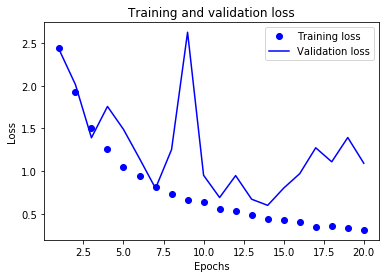

In [0]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

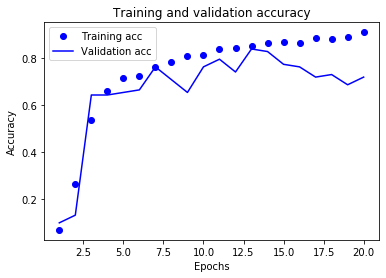

In [0]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
model.load_weights('model.h5')

In [0]:
model.evaluate(X_test, test_labels)

92/92 [==============================] - 1s 7ms/step


[0.5987147662950598, 0.8260869565217391]

#4.Testing some examples:

In [0]:
from google.colab.patches import cv2_imshow

In [0]:

EMOTION_DICT = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
def make_prediction(model, path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path, gray)

    face_cascade = cv2.CascadeClassifier(root_path + '/haarcascade_frontalface_default.xml') 
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_clip = img[y:y + h, x:x + w]
        cv2.imwrite(path, cv2.resize(face_clip, (350, 350)))
    
    # read the processed image then make prediction and display the result
    read_image = cv2.imread(path)
    cv2_imshow(read_image)
    read_image = read_image.reshape(1, 350, 350, 3)
    read_image_final = read_image / 255.0  # normalizing the image

    top_pred = model.predict(read_image_final)
    emotion_label = -1
    value = 0
    print("Predicted Expression Probabilities")
    for idx, emotion in enumerate(EMOTION_DICT):
      print(emotion, " : ", top_pred[0][idx])
      if (top_pred[0][idx] > value):
        emotion_label = idx
        value = top_pred[0][idx]
    print("Dominant Probability = " + str(EMOTION_DICT[emotion_label]))


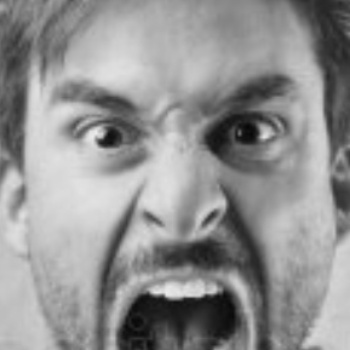

Predicted Expression Probabilities
anger  :  0.30997053
contempt  :  0.012399759
disgust  :  0.44456348
fear  :  0.05504034
happiness  :  0.032059334
sadness  :  0.07650655
surprise  :  0.043230418
Dominant Probability = disgust


In [0]:
make_prediction(model, 'test_angry.jpg')

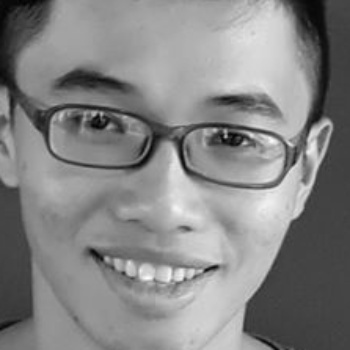

Predicted Expression Probabilities
anger  :  0.012104305
contempt  :  0.00032918798
disgust  :  0.0108796675
fear  :  0.028729746
happiness  :  0.9475371
sadness  :  0.00022725202
surprise  :  0.00017019773
Dominant Probability = happiness


In [0]:
make_prediction(model, 'test.jpg')

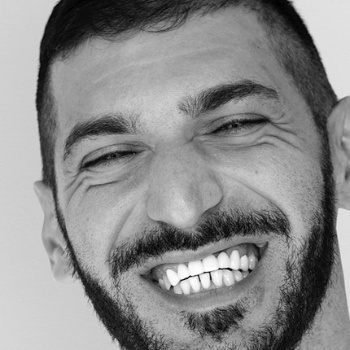

Predicted Expression Probabilities
anger  :  0.05535508
contempt  :  0.0010740983
disgust  :  0.50223774
fear  :  0.019149726
happiness  :  0.40929246
sadness  :  0.00841207
surprise  :  0.0042405254
Dominant Probability = disgust


In [0]:
make_prediction(model, 'test_happy.jpg')

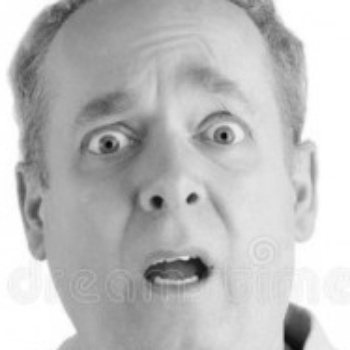

Predicted Expression Probabilities
anger  :  0.02735608
contempt  :  0.012092664
disgust  :  0.010798893
fear  :  0.15371619
happiness  :  0.0010628968
sadness  :  0.26113537
surprise  :  0.014829382
Dominant Probability = sadness


In [0]:
make_prediction(model, 'test_surprise.jpg')

In [0]:
!cd 'gdrive/'
!ls

gdrive	sample_data
